<h1>How to load your data as a matrix.</h1>

In [139]:
import nibabel as nib
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import skimage
from skimage.transform import downscale_local_mean
import scipy

nib.Nifti1Header.quaternion_threshold = -np.finfo(np.float32).eps * 10

A NIFTI file contains multiple containers (I am not familiar with all of its contents yet). Among these is the data. You can directly call the .get_data() function from the nibabel library to access just the data. 

The data is organized as:
height*width*slices

In [81]:
def open_NIFTI(filename):
    """Imports data from the NIFTI files

    Args:
        filename (string): filename and path to the NIFTI file

    Returns:
        data (3D numpy): the 3d volume of the image
        hdr_data: header of the NIFTI file
    """
    img_mri = nib.load(filename)
    data = img_mri.get_data()
    return data

In [82]:
data = open_NIFTI(r"data//example_nifti.nii")
data.shape

(256, 256, 287)

Image the data to see the different cross-sections of the brain.

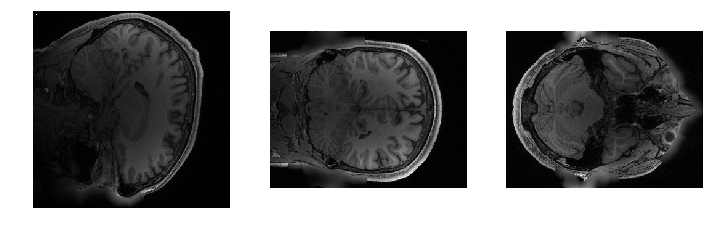

In [186]:
data[100,5,5] = 4096 

plt.figure(figsize=(12,10))

plt.subplot(1,3,1)
plt.imshow(data[100,:,:]/4096, cmap='gray')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(data[:,100,:]/4096, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(data[:,:,100]/4096, cmap='gray')
plt.axis('off')

plt.show()


# Open NIFTI file inside a zip file

MRI data is often distributed as .zip files due to their sparsity the matrix sizes can be compressed. When this is the case we must extract the data from the file first before using the openNIFTI function. We will also add the required functionality for the data to be B1 corrected.

In [109]:
def extract_NIFTI(filepath, subject_id, scan_type = 'T1', b1_corr = True):
    """ Open a zip file and read a file within it

    Args: 
        zip_filename (string): Absolute filename
        filename (string): filename of the file inside the zip
        scan_type (strng): The acquisition type to extract ('T1' or 'T2')

    Returns: 
        data
    """
    print('Filepath: ', filepath + str(subject_id) + '_3T_Structural_unproc.zip')
    zip_filename = filepath + str(subject_id) + '_3T_Structural_unproc.zip'
    
    # If the zip file is not found.
    if not zipfile.is_zipfile(zip_filename): raise NameError('Not a valid .zip file.')

    with zipfile.ZipFile(zip_filename, 'r') as zf:
        if scan_type == 'T1':
            filename_dt = str(subject_id) + '/unprocessed/3T/T1w_MPR1/' + \
                          str(subject_id) + '_3T_T1w_MPR1.nii.gz'
            filename_bc = str(subject_id) + '/unprocessed/3T/T1w_MPR1/' + \
                          str(subject_id) + '_3T_BIAS_BC.nii.gz'
            filename_ch = str(subject_id) + '/unprocessed/3T/T1w_MPR1/' + \
                          str(subject_id) + '_3T_BIAS_32CH.nii.gz'
        
        elif scan_type == 'T2':
            filename_dt = str(subject_id) + '/unprocessed/3T/T2w_SPC1/' + \
                          str(subject_id) + '_3T_T2w_SPC1.nii.gz'
            filename_bc = str(subject_id) + '/unprocessed/3T/T2w_SPC1/' + \
                          str(subject_id) + '_3T_BIAS_BC.nii.gz'
            filename_ch = str(subject_id) + '/unprocessed/3T/T2w_SPC1/' + \
                          str(subject_id) + '_3T_BIAS_32CH.nii.gz'    
            
        # If the internal file is not found.
        if not filename_dt in zf.namelist():
            raise NameError('Filename not found in the zipfile!')
                
        file = zf.extract(filename_dt)
        data_t2 = open_NIFTI(filename_dt)

        if not filename_bc in zf.namelist(): return data_t2
            
        if b1_corr == True:
            # B1 correction of the T2 images
            file = zf.extract(filename_bc)
            file = zf.extract(filename_ch)
            data_bc = open_NIFTI(filename_bc)
            data_ch = open_NIFTI(filename_ch)
            data_t2 = B1_correction(data_t2, data_bc, data_ch)
                
        shutil.rmtree(str(subject_id) + '/', ignore_errors=True) # Delete the file in the root
        return data_t2

In [129]:
data = extract_NIFTI(r'data/', 100206, 'T1', b1_corr=False)
print('Shape of volumetric image: ', data.shape)

Filepath:  data/100206_3T_Structural_unproc.zip
Shape of volumetric image:  (256, 320, 320)


# B1 Correction

For optimal signal reception coils are brought as close as possible to the subject. Thus, when using a multicoil set up this causes the coils to be tightly packed thus having smaller loop diameters. As a result we observe signals with low depth of penetration, resulting in bright signals for the external part of the subject but dimmer signals in the inner parts of the subjects. 

To resolve this issue we use the body coil image which has a nearly constant depth of penetration and the 32-channel coil image. By getting their ratio we can then modulate our MRI scan for B1 correction.

In [126]:
def B1_correction(img, data_bc, data_ch):
    # Remove 0 values in the body coil image
    data_bc[data_bc==0] = np.finfo(float).eps
    data_ch[data_ch==0] = 1
    ratio = data_bc/data_ch
    
    ratio = np.swapaxes(np.swapaxes(ratio, 0, 1), 0, 2)
    ratio = np.rot90(np.rot90(ratio))
    
    ratio = skimage.transform.resize(ratio, img.shape, mode='constant')
    img = np.multiply(ratio, img)
    return img

We will get the data from the NIFTI file with and without B1 correction.

In [127]:
data = extract_NIFTI(r'data/', 100206, 'T2', b1_corr=False)
data_b1_corr = extract_NIFTI(r'data/', 100206, 'T2')

Filepath:  data/100206_3T_Structural_unproc.zip
Filepath:  data/100206_3T_Structural_unproc.zip


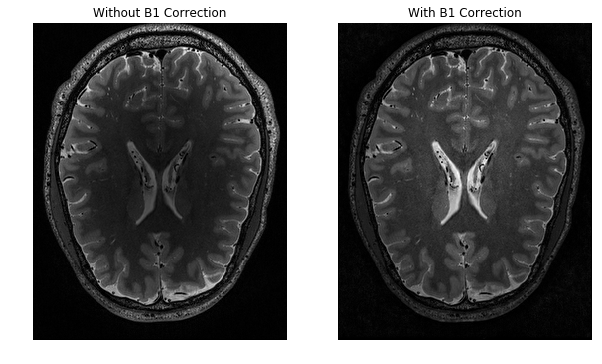

In [128]:
axial_ix = 180

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(data[:,:,axial_ix].T, 'gray')
plt.axis('off')
plt.title('Without B1 Correction')
plt.subplot(1,2,2)
plt.imshow(data_b1_corr[:,:,axial_ix].T, 'gray')
plt.axis('off')
plt.title('With B1 Correction')
plt.show()

# Manipulating the Volumetric Image

We will define two classes which can be used to extract slices and resize images to a desired dimension such that they can be used seemlessly with algorithms.

In [171]:
def extract_slice(data, slice_ix, orientation = 'axial'):
    """ Extract a slice from a volumetric image
    
    Args: 
        data (3D numpy array): The volumetric image
        slice_ix (int): The slice to extract
        orientation (string): The orientation to extract
            'axial', 'coronal', 'sagittal'
    """
    if slice_ix > 1 or slice_ix < 0: 
        raise NameError('The extracted slice should be within [0, 1]. A proportion of the volume size.')
        return None

    if orientation is 'axial':
        slice_ix = int(slice_ix * len(data[0,0,:]))
        return data[:,:,slice_ix]
    elif orientation is 'coronal':
        pass
    elif orientation is 'sagittal':
        pass
    else:
        raise NameError('Undefined orientation!')
        
def resize_image(img, output_size):
    """ Takes an image and brings it to a specified size
    
    Args:
        img (2d numpy array): The image
        output_size: the desired output shape

    Returns:
        The downscaled image
    """
    x, y = img.shape

    size = output_size * (max(x,y)//output_size)
    if output_size >= x and output_size >= y:
        size = output_size
    pad_img = skimage.transform.resize(img, (size, size), mode='constant')
    fx, fy = size//output_size, size//output_size
    return downscale_local_mean(pad_img, (fx, fy))

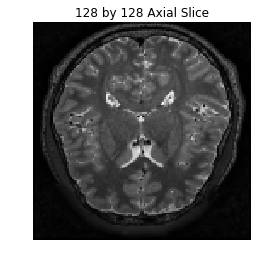

In [172]:
img = extract_slice(data_b1_corr, 0.52)
img = resize_image(img, 128)

plt.imshow(img.T, 'gray')
plt.axis('off')
plt.title('128 by 128 Axial Slice')
plt.show()

# The k-space

MR experiments acquire signals directly in the k-space, many different acquisition patterns are possible however the more popular trajectories are Cartesian, radial and spiral. From the k-space representation we reconstruct images using the inverse Fourier transform (IFFT). Inversely, from images we can retrieve the k-space by using the Fourier transform (FT).

In [152]:
def transform_to_k_space(img, acquisition = 'cartesian', sampling_percent = 1):
    """ Transforms the image to the k-space and shifts the 0-freq to the 
    center. 

    Supports 'cartesian' and 'radial' acquisition.

    Args:
        img (2d numpy array): The image
        acquisition (str): The type of acquisition scheme. 'cartesian' and 'radial'
                           supported.
        sampling_percent (int): Value in [0, 1] defining the amount of sampling
                                lines to keep.

    Returns 
        A complex 2D matrix with the FFT.
    """
    if acquisition == 'cartesian':
        n = img.shape[0]
        freq = np.fft.fft2(img)
        k_space = np.fft.fftshift(freq)
        # Performs the truncation based on the desired range
        k_space = k_space[int((1-sampling_percent)*n//2):int((1+sampling_percent)*n//2), :]
        return k_space

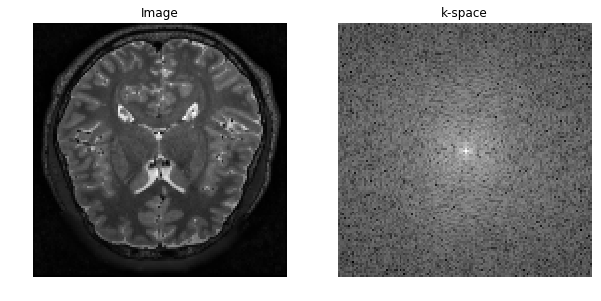

In [161]:
k_space = transform_to_k_space(img)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img.T, 'gray')
plt.axis('off')
plt.title('Image')
plt.subplot(1,2,2)
plt.imshow(np.log(np.abs(k_space)).T, 'gray')
plt.axis('off')
plt.title('k-space')
plt.show()

# Radial Acquisition

A radial acquisition can be achieved without additional components in MRI, it simply requires chnaging the pulse sequences. However, from an image attaining th eradial acquisition k-space needs some additional interpolations to correct for the non-uniform sampling of the k-space points. Thus we use the non-uniform fast Fourier transform (NUFFT).

We first determine the coordinates of all the points which we want to extract.

In [219]:
from pynufft.pynufft import NUFFT_cpu

# Number of points per radial line
n = 128
# Number of radial lines int(n*np.pi/2) is fully sampled radial acquisition
total = 100

angles = np.repeat(np.arange(0, np.pi, np.pi/total), n)
radii = np.asarray(list(np.linspace(-1,1,n)) * total)
om = np.asarray([[r*np.cos(a), r*np.sin(a)] for r, a in zip(radii, angles)])
om = om * np.pi

print('Number of points: ', angles.shape)

Number of points:  (12800,)


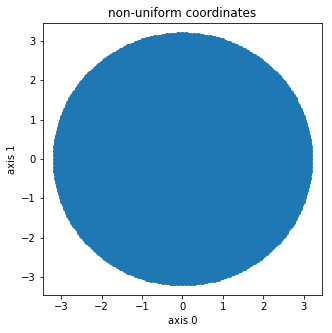

In [203]:
plt.figure(figsize=(5,5))
plt.plot(om[:,0],om[:,1],'o')
plt.title('non-uniform coordinates')
plt.xlabel('axis 0')
plt.ylabel('axis 1')
plt.show()

In [220]:
# image size
Nd = (128, 128)
# k-space size
Kd = (128, 128)
Jd = (4, 4)  # interpolation size

print('setting image dimension Nd...', Nd)
print('setting spectrum dimension Kd...', Kd)
print('setting interpolation size Jd...', Jd)

NufftObj = NUFFT_cpu()
NufftObj.plan(om, Nd, Kd, Jd)

setting image dimension Nd... (128, 128)
setting spectrum dimension Kd... (128, 128)
setting interpolation size Jd... (4, 4)


C:\Users\eee\Anaconda3\lib\site-packages\pynufft\src\_helper\helper.py:380: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef = numpy.linalg.lstsq(numpy.nan_to_num(X), numpy.nan_to_num(sn_kaiser))[0]


0

(12800,)


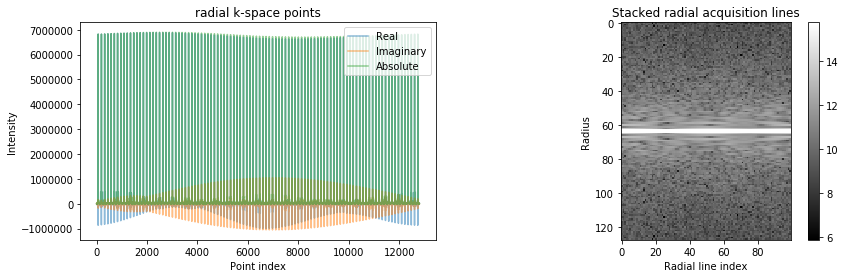

In [225]:
y = NufftObj.forward(img)
print(y.shape)

plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
real, = plt.plot(np.real(y), label = 'Real', alpha=0.5)
imag, = plt.plot(np.imag(y), label = 'Imaginary', alpha=0.5)
abso, = plt.plot(np.abs(y), label = 'Absolute', alpha=0.5)
plt.xlabel('Point index')
plt.ylabel('Intensity')
plt.legend(loc = 'upper right')
plt.title('radial k-space points')

plt.subplot(1,2,2)
plt.imshow(np.log(np.abs(y)).reshape((total, n)).T)
plt.gray()
plt.colorbar()
plt.xlabel('Radial line index')
plt.ylabel('Radius')
plt.title('Stacked radial acquisition lines')
plt.show()